<a href="https://colab.research.google.com/github/MMathisLab/Nx-435_EPFL/blob/mwm%2Fcebra/Notebooks/CEBRA__NX435_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 👋  Welcome to the CEBRA demo!

![alt text](https://images.squarespace-cdn.com/content/v1/57f6d51c9f74566f55ecf271/6f3943a1-b76d-4674-9df9-87aebd33e517/cebralogo.png?format=2500w)


 - Hello, NX-435!

 - This demo is aimed at showing you how to use CEBRA on the hippocampus demo data.
 - But for many more options, ideas, and demos we really recommend checking out: http://cebra.ai/demos
 - For questions, please contact Mackenzie Mathis: mackenzie.mathis@epfl.ch
 - please consider giving our project a ⭐️ on GitHub: https://github.com/AdaptiveMotorControlLab/CEBRA Danke! 🤗

##### Authored by Anastasiia Filippova & Mackenzie Mathis (MW Mathis Lab @ EPFL)


In [ ]:
!pip install cebra

In [2]:
import cebra
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

import cebra.integrations.matplotlib as cebra_plot

from cebra import CEBRA

In [3]:
hippocampus_pos = cebra.datasets.init('rat-hippocampus-single-achilles')

/usr/local/lib/python3.10/dist-packages/cebra/__init__.py:118: UserWarning: Your code triggered a lazy import of cebra.datasets. While this will (likely) work, it is recommended to add an explicit import statement to you code instead. To disable this warning, you can run ``cebra.allow_lazy_imports()``.
  warnings.warn(


## Data preprocessing & checks

### Let's quickly look at the data:

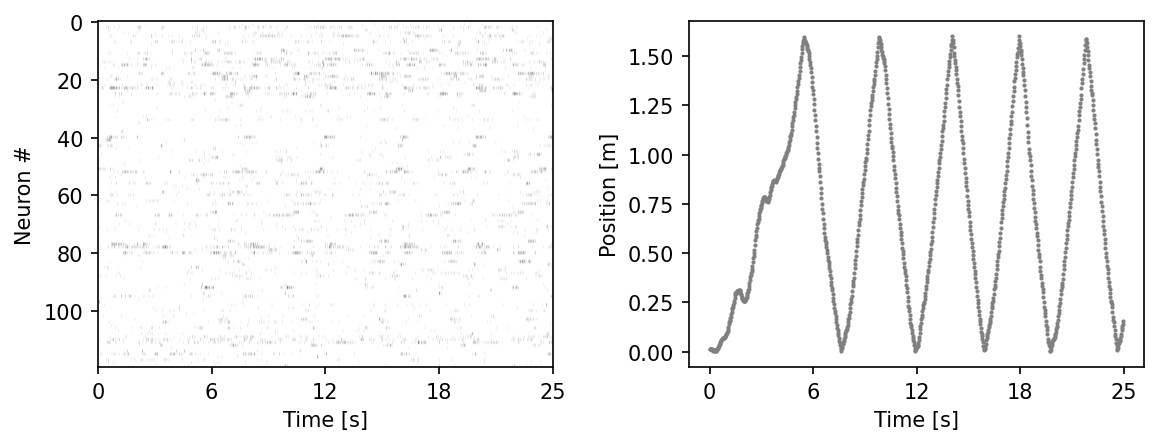

In [4]:
fig = plt.figure(figsize=(9,3), dpi=150)
plt.subplots_adjust(wspace = 0.3)
ax = plt.subplot(121)
ax.imshow(hippocampus_pos.neural.numpy()[:1000].T, aspect = 'auto', cmap = 'gray_r')
plt.ylabel('Neuron #')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))

ax2 = plt.subplot(122)
ax2.scatter(np.arange(1000), hippocampus_pos.continuous_index[:1000,0], c = 'gray', s=1)
plt.ylabel('Position [m]')
plt.xlabel('Time [s]')
plt.xticks(np.linspace(0, 1000, 5), np.linspace(0, 0.025*1000, 5, dtype = int))
plt.show()

# 🦓 CEBRA training

- we recommend to start with CEBRA-Time, as this is unsupervised:

- you can find our suggested workflow here: https://cebra.ai/docs/usage.html

### CEBRA-Time

We will train CEBRA-Time first.

Models will be trained with default parameters, but they can be tuned with [grid-search](https://cebra.ai/docs/api/pytorch/helpers.html#module-cebra.grid_search).

`time_offset` represents the time gap between neural samples that form positive pair.

In [5]:
# No. of iterations to train:
iterations = 5000

In [6]:
cebra_time_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.12,
                        output_dimension=3,
                        max_iterations=iterations,
                        distance='cosine',
                        conditional='time',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [7]:
cebra_time_model.fit(hippocampus_pos.neural)
cebra_time = cebra_time_model.transform(hippocampus_pos.neural)

pos: -0.8472 neg:  6.3693 total:  5.5221 temperature:  1.1200: 100%|██████████| 5000/5000 [01:08<00:00, 72.55it/s]


## Analyze the embedding, part 1:
- plot embedding #1 & the loss; it should be < 6

In [8]:
# interactive plotting

cebra_time_df = pd.DataFrame(cebra_time, columns=['x', 'y', 'z'])
cebra.plot_embedding_interactive(cebra_time, cebra_time_df.index, cmap='magma', s=10)

<Figure size 500x500 with 0 Axes>

<Axes: xlabel='Steps', ylabel='InfoNCE Loss'>

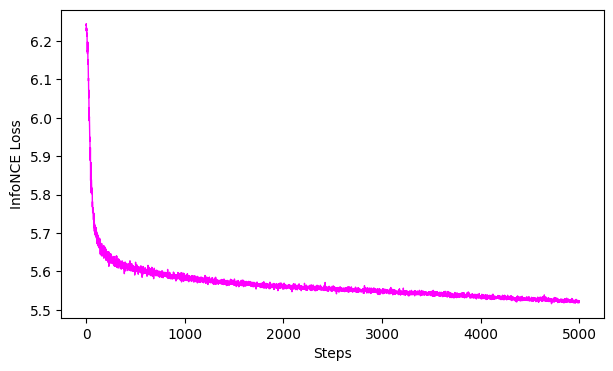

In [9]:
cebra.plot_loss(cebra_time_model)

### Next, given we see some structure (yay 🎉), let's test a few more models ....

# 🦓 CEBRA-Behavior

Now lets train cebra model guided by behaviour labels.

In order to do this we need to change sampling distribution in the CEBRA model from 'time' to 'time-delta'.

In [10]:
cebra_beh_model = CEBRA(model_architecture='offset10-model',
                        batch_size=512,
                        learning_rate=3e-4,
                        temperature=1.,
                        output_dimension=3,
                        max_iterations=iterations,
                        distance='cosine',
                        conditional='time_delta',
                        device='cuda_if_available',
                        verbose=True,
                        time_offsets=10)

In [11]:
cebra_beh_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
cebra_posdir = cebra_beh_model.transform(hippocampus_pos.neural)

#for the demo we don't save the models, but if you want to ...
#cebra_beh_model.save("cebra_cebra_beh_model.pt")

pos: -0.8964 neg:  6.4155 total:  5.5192 temperature:  1.0000: 100%|██████████| 5000/5000 [01:00<00:00, 83.21it/s]


In [12]:
cebra.plot_embedding_interactive(cebra_posdir,hippocampus_pos.continuous_index.numpy()[:, 0], cmap='magma')

<Figure size 500x500 with 0 Axes>

In [13]:
#TODO: plot the loss of the model

## Comparing Models

- The lower the loss value at the same iter, the better the fit

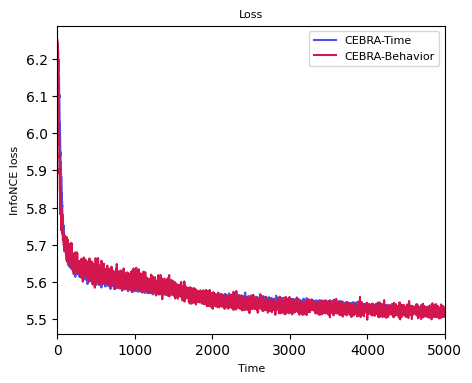

In [14]:
plt.figure(figsize=(5,4))
plt.plot(cebra_time_model.state_dict_['log']['total'],
         label='CEBRA-Time', c="#4854e9")
plt.plot(cebra_beh_model.state_dict_['log']['total'],
         label='CEBRA-Behavior', c="#d4164f")
plt.xlim(left = 0, right = iterations)
plt.xlabel('Time', fontsize=8)
plt.ylabel('InfoNCE loss', fontsize=8)
plt.title('Loss', fontsize=8)
plt.legend(fontsize=8)

## We also want to check consistency, here across runs!

 - this is also useful to compare across animals (see Schneider, Lee, Mathis Nature 2023, Figure 1)
 - or compare across brain areas, tasks, etc .. anything you want to compare 🧠

In [15]:
number_runs = 4
cebra_consistency = {'models': [], 'embeddings': []}

for i in range(number_runs):
    cebra_beh_model = CEBRA(model_architecture='offset10-model',
                            batch_size=512,
                            learning_rate=3e-4,
                            temperature=1.,
                            output_dimension=3,
                            max_iterations=iterations,
                            distance='cosine',
                            conditional='time_delta',
                            device='cuda_if_available',
                            verbose=True,
                            time_offsets=10)
    cebra_beh_model.fit(hippocampus_pos.neural, hippocampus_pos.continuous_index.numpy())
    embs = cebra_beh_model.transform(hippocampus_pos.neural)
    cebra_consistency['models'].append(cebra_beh_model)
    cebra_consistency['embeddings'].append(embs)

pos: -0.8944 neg:  6.4126 total:  5.5181 temperature:  1.0000: 100%|██████████| 5000/5000 [00:59<00:00, 84.24it/s]
pos: -0.8771 neg:  6.4173 total:  5.5402 temperature:  1.0000: 100%|██████████| 5000/5000 [01:01<00:00, 81.51it/s]
pos: -0.8919 neg:  6.4125 total:  5.5205 temperature:  1.0000: 100%|██████████| 5000/5000 [01:07<00:00, 74.26it/s]
pos: -0.9111 neg:  6.4168 total:  5.5057 temperature:  1.0000: 100%|██████████| 5000/5000 [00:59<00:00, 83.55it/s]


In [16]:
scores, pairs, runs = cebra.sklearn.metrics.consistency_score(embeddings=cebra_consistency['embeddings'],
                                                                                       between='runs')

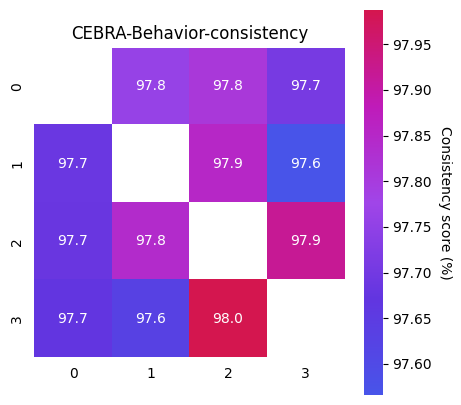

In [17]:
%matplotlib inline
ax = cebra_plot.plot_consistency(scores,
                                 pairs=pairs,
                                 datasets=runs,
                                 title="CEBRA-Behavior-consistency", cmap='cebra')